<a href="https://colab.research.google.com/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_visits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-State-Visits Testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)
In this tutorial, we’ll explore how to perform across-state-visits testing using the [GLHMM toolbox](https://github.com/vidaurre/glhmm), based on the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). This test is useful for examining whether brain states, decoded from neural data, are associated with changes in a continuous variable recorded alongside the brain activity.

To focus on the statistical testing, we use synthetic data:

For this tutorial:

* $D$: the Viterbi path — the sequence of brain states decoded by an HMM at each time point.

* $R$: a continuous signal recorded alongside the brain data (e.g., pupil size, heart rate).

> **Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_visits.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Preparation](#preparation)
2. [Load data](#load-data)
3. [Across-Visits testing - Monte Carlo resampling](#across-visits)
    * [Multivariate](#perm-regression)
    * [Univariate](#perm-correlation)
    * [One-state-vs-the-rest (OSR)](#perm-rest)
    * [One-state-vs-another-state (OSA)](#perm-pairs)

# Preparation <a id="preparation"></a>

If you don't have the **GLHMM package** installed, this notebook will help you install it automatically.

We will also download example data from the Open Science Framework (OSF).

---


In [1]:
# Install packages if needed
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Installing GLHMM...")
    !pip install git+https://github.com/vidaurre/glhmm

# Install osfclient if missing
try:
    import osfclient
except ImportError:
    print("Installing osfclient...")
    !pip install osfclient

# Now import everything we need
import numpy as np
from pathlib import Path
from glhmm import glhmm, preproc, io, graphics, statistics


# Load and Prepare Data <a id="load-data"></a>
To get started, we’ll download the synthetic data needed use it to run the across-state-visits test.
If they already exist, we will skip downloading.

We’ll use the `osfclient` package to fetch the files directly from the Open Science Framework (OSF). If you prefer, you can also download them manually from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

In [ ]:
# Set up data directory
data_dir = Path.cwd() / "files" / "data_statistical_testing"

if not data_dir.exists():
    print(f"Creating {data_dir}...")
    data_dir.mkdir(parents=True, exist_ok=True)
else:
    print(f"Data directory {data_dir} already exists.")

# Files to download
files = [
    "vpath.npy",
    "sig_data.npy",
]

# Download the files from OSF if they don't exist locally
for fname in files:
    local_path = data_dir / fname
    remote_path = f"data_statistical_testing/{fname}"

    if local_path.exists():
        print(f"✓ {fname} already exists — skipping.")
    else:
        print(f"Downloading {fname}...")
        # as_posix() ensures forward slashes on Windows for shell compatibility
        !osf -p 8qcyj fetch {remote_path} {local_path.as_posix()}


Data directory c:\Users\au323479\Github\glhmm_28_04\docs\notebooks\files\data_statistical_testing already exists.
✓ vpath.npy already exists — skipping.
✓ sig_data.npy already exists — skipping.


**Load and check the data**\
The folder `data_statistical_testing` contains:

- **`vpath`**: decoded HMM state sequence (Viterbi path)  
  Shape: **(n_timepoints, n_states)** — here **5000 × 5**, where 5000 timepoints are decoded into 5 possible HMM states.  
  Each row represents a timepoint; each column corresponds to a specific state.

- **`sig_data`**: simulated continuous signal recorded alongside the brain data  
  Shape: **(n_timepoints, 1)** — a 1D array with one value per timepoint.


> **Note**: For details on training from scratch, follow the tutorials [*Standard Gaussian Hidden Markov Model*](./GLHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb). In this notebook, we use precomputed Viterbi path to focus on the across-state-visits testing.

If you wish to compute the Viterbi path yourself after training a model, you can use the following code:

```python
vpath = hmm.decode(X=None, Y=D_data, indices=idx, viterbi=True)

Let’s load the files into memory:

In [ ]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "files"/ "data_statistical_testing"

# Data
vpath = np.load(PATH_DATA/"vpath.npy")
sig_data = np.load(PATH_DATA/"sig_data.npy")

Data dimension of vpath: (5000, 5)
Data dimension of sig_data: (5000, 1)


**Check the shape of each dataset**
This step helps confirm that all files loaded correctly and match the expected dimensions.

In [5]:
# Check that dimensions are correct
print(f"Data dimension of vpath: {vpath.shape}")
print(f"Data dimension of sig_data: {sig_data.shape}")

Data dimension of vpath: (5000, 5)
Data dimension of sig_data: (5000, 1)


### Visualise Viterbi path
Now, let's visualise the distinct states in the Viterbi path from our trained Hidden Markov Model.

The plot provides a clear depiction of each time point assigned to a specific HMM state, with each state represented by a distinct color. This visualisation allows us to easily discern the temporal distribution and transitions between different states.

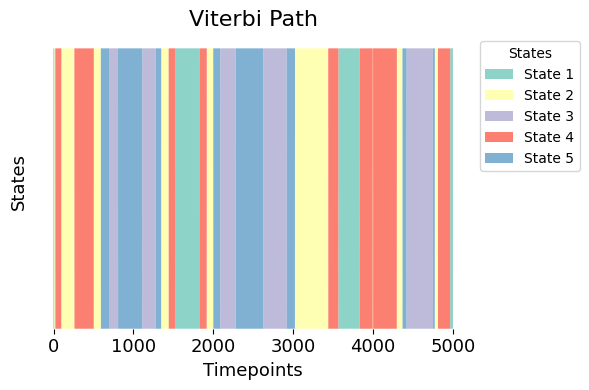

In [5]:
graphics.plot_vpath(vpath, figsize=(6,4), ylabel="States")

**Plot Viterbi path and discrete states**\
This plot shows the brain states identified by the HMM over time, with each state represented by a different color. It makes it easy to see which state the model assigned to each moment.

At the top of the plot, there’s an extra layer that shows the state assignments as numbers on the y-axis. For example, if you see the number 5 on the y-axis in blue, it means the data at that moment belongs to state 5. This format is similar to Figure 3D in our paper.

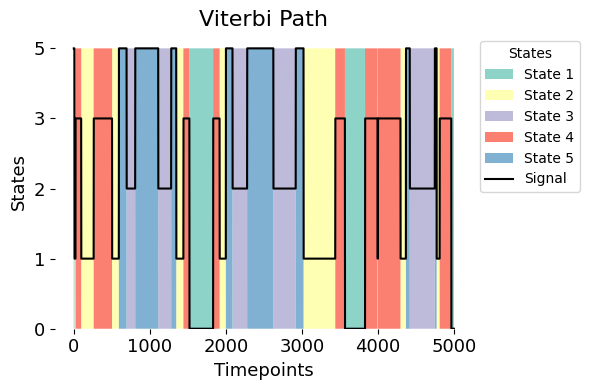

In [6]:
# Create a 1D array from the one-hot encoded Viterbi path data
vpath_1D=statistics.generate_vpath_1D(vpath)

# Plot discrete states with the Viterbi path
graphics.plot_vpath(vpath,vpath_1D, figsize=(6,4), ylabel="States", yticks=True)

**Plot Viterbi path and signal**\
This plot shows the Viterbi path (D) together with the signal (R). Each time point is color-coded based on the brain state assigned by the HMM, making it easy to compare the signal and the state changes.

To create this plot, the signal data is adjusted to fit on the same scale as the Viterbi path (from 0 to 1). This adjustment is just for visualisation, helping us overlay the two and see how well the model reflects the patterns in the signal.

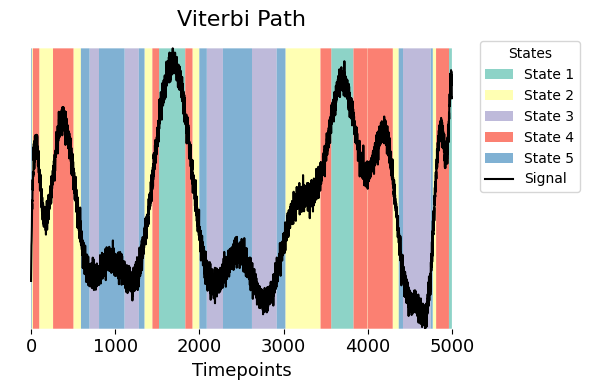

In [7]:
# Plot vpath and sig_data
graphics.plot_vpath(vpath,sig_data, figsize=(6,4))

Let's delve into the values assigned to each state. To achieve this, we calculate the average of the values associated with each state.

This brief analysis provides insights into the typical or central values characterizing each state. By examining these averages, we gain a clearer understanding of the distinctive characteristics and patterns represented by the different states in our HMM.



In [8]:
vpath_1D=statistics.generate_vpath_1D(vpath)
val_state =[np.mean(sig_data[vpath_1D == i+1]) for i in range(vpath.shape[1]) ]
val_state

[np.float64(4.912042797300882),
 np.float64(-0.05858422375450776),
 np.float64(-3.795696791047377),
 np.float64(2.352225972831181),
 np.float64(-2.5030418147224505)]

The above figure shows an relation between the simulated measurements (```sig_data```) and the Viterbi path (```vpath```). Notably, a closer examination of the variable ```val_state``` shows distinct values assigned to each specific state: 

* State 1 (green) aligns with highest value 
* State 2 (yellow) corresponds to values in the middle, close to 0. 
* State 3 (purple) corresponds to the lowest negative values.
* States 4 (red) and State 5 (blue) are values that fall between the extremes values. 
This gives us a perspective on the behavioral dynamics across different states on our signal.

# **3. Across-Visits testing - Monte Carlo resampling** <a id="across-visits"></a>
As we move on to the next part of this tutorial, let's dive into how we can use the ```test_across_state_visits``` function.
This function helps us to find connections between HMM state time course (D) and behavioral variables or individual traits (R) using Monte Carlo resampling.


**Monte Carlo resampling**\
Monte Carlo resampling does not assume any particular data distribution and the procedure shuffles the data around to create a null distribution. This null distribution comes in handy for testing our hypotheses without making any assumptions about the data.
This null distribution becomes our benchmark to test the question: is there any real difference or relationship between the variables we're interested in?

## **Across visits - Multivariate** <a id="perm-regression"></a>

The multivariate analysis aims to determine how the Viterbi path (```D_data```), characterized by different states, contributes to explaining the observed variability in the simulated signal (```R_data```). By quantifying explained variance, this analysis evaluates whether state transitions significantly influence changes in signal values over time.

A Monte Carlo resampling for explained variance assesses the statistical significance of this relationship. A significant result indicates that the Viterbi path meaningfully explains the signal's variability, while a non-significant result suggests the observed relationship is likely due to random chance.

To run the test, use the across_state_visits function by providing the inputs:

**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "multivariate"```: Specifies that the test should perform multivariate analysis.
* ```Nnull_samples```: Number of samples (optional, default is 1000).

For details on additional settings, refer to the function documentation.

In [9]:
# Set the parameters for across_visits testing
method = "multivariate"
Nnull_samples = 10_000 # Number of resamples (default = 1000)
result_multivariate  =statistics.test_across_state_visits(vpath, 
                                                          sig_data, 
                                                          method=method,
                                                          Nnull_samples=Nnull_samples)

100%|██████████| 10000/10000 [00:08<00:00, 1232.29it/s]


The result is stored in a dictionary called `result_multivariate`. Here's what it contains:

* ```pval```: array of p-values with shape (1, q). Each value corresponds to a behavioral variable. See the [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python) for details.

* ```base_statistics```: test statistics computed from the original (unshuffled) data. For multivariate tests, this corresponds to the F-statistic.

* ```null_stat_distribution```: array of test statistics obtained from each Monte Carlo resampling.

* ```statistical_measures```: dictionary indicating which statistic was used (e.g., F-statistic).

* ```test_type```: Indicates the type of statistical test performed. In this case, it is ```across_visits```.

* ```method```:  test method used, here it is `"multivariate"`

* ```max_correction```: whether MaxT correction was applied during Monte Carlo resampling.

* ```Nnull_samples```: number of Monte Carlo samples used to generate the null distribution.

* ```test_summary```: structured summary of the results, including F-statistics and model coefficients.



**Visualisation of results**\
Now that we have performed our test, we can then visualise the p-value array.\
We will import the function ```plot_p_values_bar``` from module ```graphics.py```
> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.

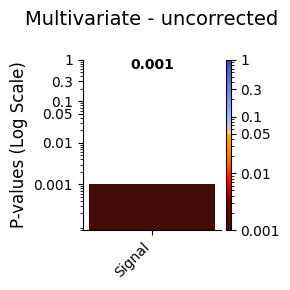

In [8]:
# Plot p-values
graphics.plot_p_values_bar(result_multivariate["pval"], 
                           title_text ="Multivariate - uncorrected",
                           figsize=(3, 3), 
                           alpha=0.05, 
                           xticklabels=["Signal"])

#### Conclusion - Multivariate
The multivariate test between the Viterbi path and the signal resulted in a statistically significant p-value. This indicates a meaningful relationship between the brain states identified by the HMM and the signal, suggesting that the states capture important dynamics related to the observed data.

## **Across visits - Univariate** <a id="perm-correlation"></a>

The univariate analysis evaluates pairwise relationships between discrete states in the Viterbi path (```D_data```) and the variability in the signal (```R_data```). Each state is tested individually against the signal, resulting in one p-value per state. For example, with 5 states and 1 signal, the test will produce 5 p-values.

The goal is to assess whether specific states in the Viterbi path significantly contribute to changes in the signal values over time. A Monte Carlo resampling determines the statistical significance of these relationships:

To run the test, we set the following parameters:

**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "univariate"```: Specifies that the test should perform multivariate analysis.
* ```Nnull_samples```: Number of samples (optional, default is 1000).

The function ```test_across_state_visits``` is used as follows:


In [9]:
# Set the parameters for across_visits testing
method = "univariate"
Nnull_samples = 10_000
result_univariate  =statistics.test_across_state_visits(vpath, 
                                                        sig_data, 
                                                        method=method,
                                                        Nnull_samples=Nnull_samples)

100%|██████████| 10000/10000 [00:19<00:00, 514.45it/s]


Now that we have the Monte Carlo resampling distribution ['test_statistic] as we can see, it is because we set ```test_statistic_option=True```

**Visualisation of results**\
We can now plot the p-values over time using the `plot_p_value_matrix` function from the `graphics` module.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


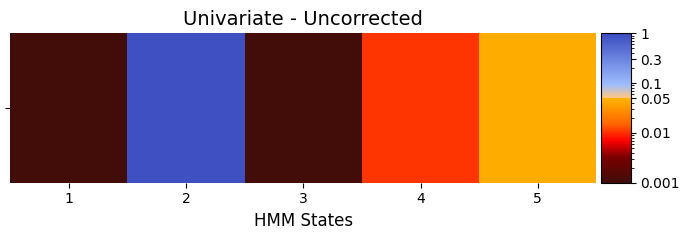

In [10]:
# Plot p-values
graphics.plot_p_value_matrix(result_univariate["pval"].T, 
                             title_text ="Univariate - Uncorrected",
                             figsize=(7, 2.5), 
                             xlabel="HMM States", 
                             alpha=0.05, 
                             x_tick_min=1)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

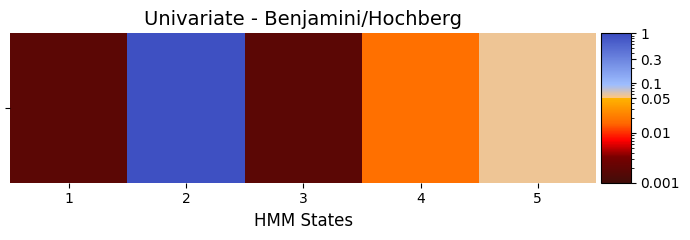

In [11]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate, 
                                                               method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected.T, title_text ="Univariate - Benjamini/Hochberg",
                             figsize=(7, 2.5), 
                             xlabel="HMM States", 
                             x_tick_min=1)

Instead of using a heatmap, we can also visualise the results with a bar plot with the function `plot_p_values_bar`

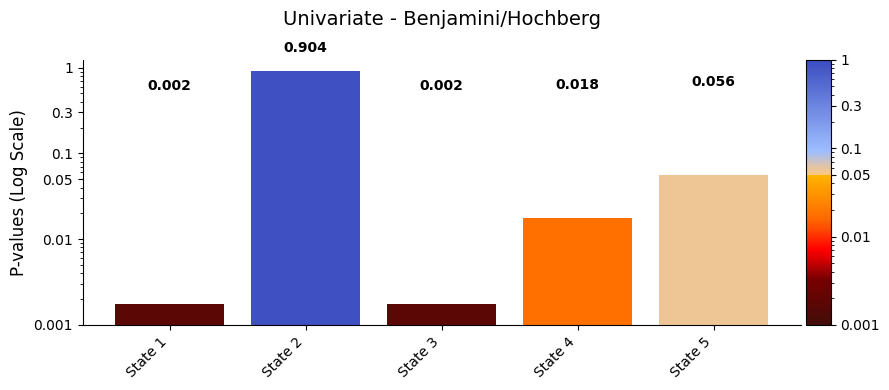

In [12]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(pval_corrected))] # construct the variable names
graphics.plot_p_values_bar(pval_corrected,
                           alpha = alpha, 
                           xticklabels=variables, 
                           title_text="Univariate - Benjamini/Hochberg")

**Plot Monte Carlo resampling distribution**\
Presented here are the test statistics(```result["null_stat_distribution"]```) of our Monte Carlo resampling distributions for different states.\
The red line shows the observed statistic, while the datapoints of the histogram represent the Monte Carlo resampling distribution

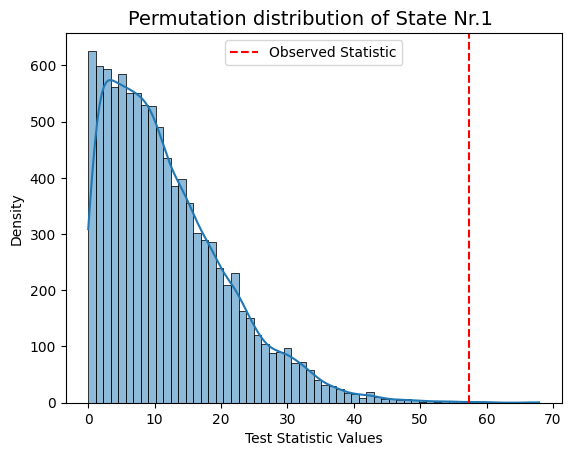

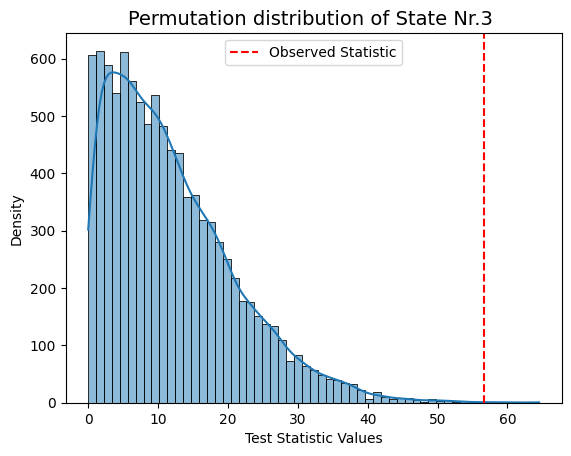

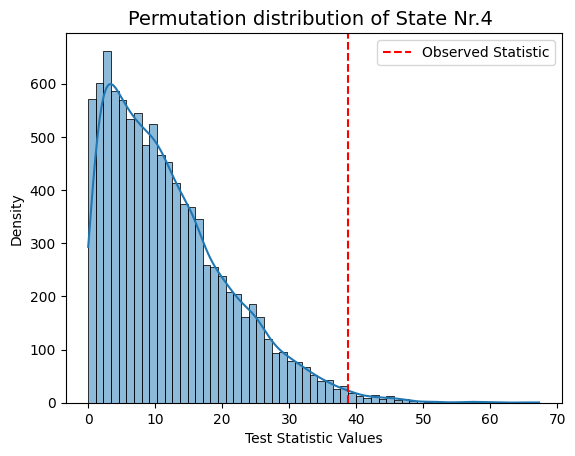

In [13]:
# Plot test statistics for pvals
significant_timestamp_position = np.where(pval_corrected < alpha)
for i in significant_timestamp_position[0]:
    graphics.plot_Monte Carlo resampling_distribution(result_univariate["null_stat_distribution"][:,i],
                                           title_text=f"Monte Carlo resampling distribution of State Nr.{i+1} ")

#### Conclusion - Univariate
The results show that states 1, 3, and 4 have a significant relationship with the signal, while states 2 and 5 do not. The signal's highest peak aligns with state 1, the lowest with state 3, and the second-highest with state 4, supporting these findings.

This suggests that states with extreme signal values have a stronger influence on the signal's changes, while states 2 and 5 may have a weaker or less clear impact.


## **Across visits -  One-state-vs-the-rest (OSR)** <a id="perm-rest"></a>
The OSR test assesses whether a specific state in the Viterbi path (`D_data`) significantly differs from the combined influence of all other states on the signal (`R_data`). This test generates five p-values, one for each state.

By default, the test checks if a state is larger than the rest using `state_com='larger'`. To test if a state is smaller, set `state_com='smaller'`.

**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "ors"```: Specifies that the test should perform multivariate analysis.
* ```Nnull_samples```: Number of resamples (optional, default is 1000).


In [14]:
# Set the parameters for across_visits testing
method = "osr"
Nnull_samples = 10_000

result_one_vs_rest  =statistics.test_across_state_visits(vpath, 
                                                         sig_data, 
                                                         method=method,
                                                         Nnull_samples=Nnull_samples)

100%|██████████| 10000/10000 [00:23<00:00, 422.80it/s]


**Visualisation of results**\
We can now plot the p-values over time using the `plot_p_values_bar` function from the `graphics` module.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


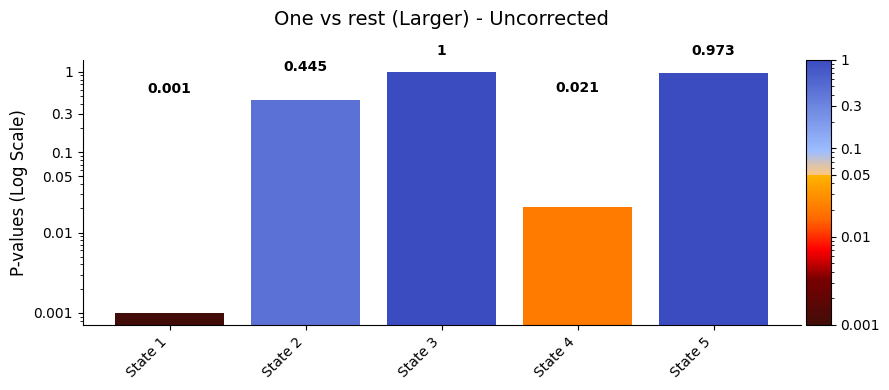

In [15]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(result_one_vs_rest["pval"]))] # construct the variable names
title_text = "One vs rest (Larger) - Uncorrected"
graphics.plot_p_values_bar(result_one_vs_rest["pval"],
                           alpha = alpha, 
                           xticklabels=variables, 
                           title_text=title_text)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

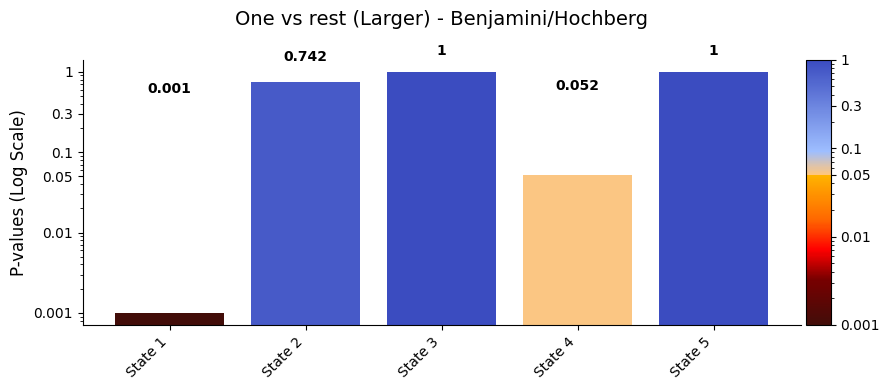

In [16]:
pval_corrected, _ =statistics.pval_correction(result_one_vs_rest, 
                                              method='fdr_bh')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected,alpha = alpha, 
                           xticklabels=variables, 
                           title_text="One vs rest (Larger) - Benjamini/Hochberg")


In [17]:
val_state

[np.float64(4.912042797300882),
 np.float64(-0.05858422375450776),
 np.float64(-3.795696791047377),
 np.float64(2.352225972831181),
 np.float64(-2.5030418147224505)]

#### Conclusion - One vs rest
After applying the Benjamini/Hochberg method to control the False Discovery Rate (FDR), the adjusted p-values for the one vs. rest test are:

* State 1: 0.005 
* State 2: 0.724  
* State 3: 1 
* State 4: 0.048
* State 5: 1

States 1 and 4, which have the lowest adjusted p-values, correspond to the highest values in `sig_data`. A significant p-value in the one vs. rest test indicates that the mean signal for a specific state is significantly different from the combined influence of all other states.

## **Across visits - One-state-vs-another-state (OSA)** <a id="perm-pairs"></a>
The OSA test compares the mean signal differences between pairs of states (e.g., state 1 vs. state 2, state 1 vs. state 3, etc.). This test evaluates whether the observed mean difference between specific state pairs is statistically significant.


**Inputs**:

* ```D_data```: The Viterbi path.
* ```R_data```: The simulated signal.

**Settings**:

* ```method = "osa"```: Specifies that the test should perform multivariate analysis.
* ```Nnull_samples```: Number of resamples (optional, default is 1000).

In [18]:
# Set the parameters for across_visits testing
method = "osa"
Nnull_samples = 10_000
test_statistics_option=True

result_state_pairs  =statistics.test_across_state_visits(vpath, 
                                                         sig_data, 
                                                         method=method,
                                                         Nnull_samples=Nnull_samples,)

Pairwise comparisons: 100%|██████████| 10/10 [02:08<00:00, 12.86s/it]


**Visualisation of results**\
Now that we have performed our test, we can then visualise the p-value array.
We will plot the p-values using the function ```plot_p_value_matrix```. Notably, in this instance, we designate the values on the diagonal as NaN (Not a Number) since these values are expected to be zeros and can be safely ignored in the visualisation.

> Lower p-values (below α = 0.05) are shown in <span style="color:red; font-weight:bold;">warm colours</span>, while higher p-values are shown in <span style="color:blue; font-weight:bold;">cool colours</span>.


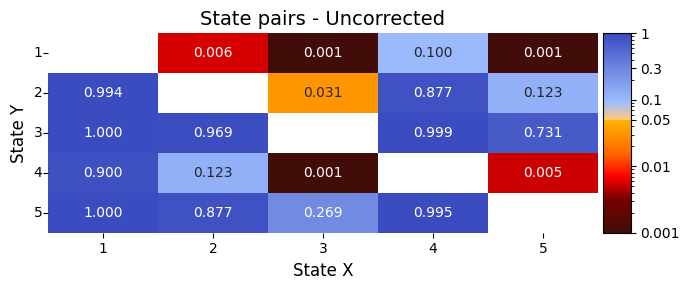

In [19]:
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(result_state_pairs["pval"], 
                             title_text ="State pairs - Uncorrected",
                             figsize=(7, 3), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True,
                             x_tick_min=1)

**Interpreting the p-value matrix**\
The p-value matrix has a shape of (number of states × number of states). Each entry shows the statistical comparison between two brain states.

* **Values below the diagonal** (lower-left) correspond to tests where the row state is compared as less than the column state (State X < State Y).

* **Values above the diagonal** (upper-right) correspond to tests where the row state is compared as greater than the column state (State X > State Y).

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

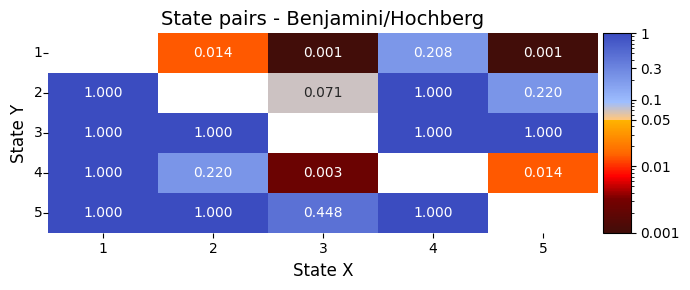

In [20]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_state_pairs, method='fdr_bh')
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, 
                             title_text ="State pairs - Benjamini/Hochberg" ,
                             figsize=(7, 3), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True,
                             x_tick_min=1)

In [21]:
# Look at the val_sates values
val_state

[np.float64(4.912042797300882),
 np.float64(-0.05858422375450776),
 np.float64(-3.795696791047377),
 np.float64(2.352225972831181),
 np.float64(-2.5030418147224505)]

#### Conclusion - state pairs
The results show clear differences in the signal between certain pairs of brain states:

* **State 1** (the highest signal value) is significantly different from states 2, 3, and 5.
* **State 3** (the lowest signal value) is significantly different from states 1 and 4.
* **States 4 and 5**, which are in the middle, also show a clear difference from each other and from state 1.

These differences suggest that specific pairs of brain states are linked to noticeable changes in the signal. This could help us understand how the signal shifts during transitions between states, such as when studying responses to pain.
